# Load required modules and classes

In [19]:
# Standard Library Imports
import asyncio
import json
import math
import os
import pickle
from datetime import datetime, timedelta

# Third-Party Library Imports
import dcor
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from aiohttp import ClientError
from starknet_py.net.full_node_client import FullNodeClient

# Local Imports
from src.data.ekubo_data import EkuboData  # Importing the EkuboData class
from src.ekubo_math import get_token_order, get_pool_fee_touse, get_tick_spacing_touse, get_liquidity_from_token1_capital

# Defining the constants to use

In [4]:
# Tokens in the LP
address1 = '0x42b8f0484674ca266ac5d08e4ac6a3fe65bd3129795def2dca5c34ecc5f96d2'  # wstETH
address2 = '0x49d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7'  # ETH

token0_address, token1_address = get_token_order(address1, address2)
print(f"Token0 Address: {token0_address}, Token1 Address: {token1_address}")

# existing values from the website 
pool_fee = 0.001  # in %
tick_spacing = 0.002  # in %

# fee and tick spacing to use
pool_fee_touse = 3402823669209384797702963685910118
# pool_fee_touse = get_pool_fee_touse(pool_fee)
tick_spacing_touse = get_tick_spacing_touse(tick_spacing)
print(f"Pool Fee to use: {pool_fee_touse}")
print(f"Tick Spacing to use: {tick_spacing_touse}")

Token0 Address: 0x42b8f0484674ca266ac5d08e4ac6a3fe65bd3129795def2dca5c34ecc5f96d2, Token1 Address: 0x49d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7
Pool Fee to use: 3402823669209384797702963685910118
Tick Spacing to use: 20


# Initializing EkuboData class for loading data

In [5]:
# Initialize the data loader with the required parameters
ekubo_data = EkuboData(
    client_url="https://starknet-mainnet.public.blastapi.io", 
    contract_address="0x00000005dd3d2f4429af886cd1a3b08289dbcea99a294197e9eb43b0e0325b4b", # Ekubo
    token0_address=token0_address,  # wstETH Address
    token1_address=token1_address,  # ETH Address
    pool_fee=pool_fee_touse,
    tick_spacing=tick_spacing_touse
)

# Load data from src/data

In [7]:
# Load events from files
events_response_positions_updated = ekubo_data.load_events_from_file('data/events_response_positions_updated.pkl')
combined_events_response_swap = ekubo_data.load_events_from_file('data/combined_events_response_swap.pkl')
# events_response_positions_updated = events_response_positions_updated.events
# print(events_response_positions_updated.events[0])
# print(combined_events_response_swap[0])

# Filter the data based on the liquidity pool, tick spacing and pool fee provided earlier

In [8]:
# Process the events to filter relevant data and create DataFrames
df_liquidity, df_swap = ekubo_data.process_events(events_response_positions_updated.events, combined_events_response_swap)

# Display the first few rows of the liquidity and swap DataFrames
print("Liquidity DataFrame:")
display(df_liquidity.head())
print(len(df_liquidity))
print("Swap DataFrame:")
display(df_swap.head())
print(len(df_swap))

Liquidity DataFrame:


,block_number,transaction_hash,delta_liquidity,tick_lower,tick_upper
0,655177,2879145539418839403171763982604352401380370371...,27408128235124552785321,158280,158460
1,655424,1279209847316592012798496238689033441847594858...,-99209107691145427163307,158400,158440
2,655424,2236106133222411803388378305320859355758706418...,262573697381870119149,158000,158800
3,655424,3387282097104070895993181893437770629177012930...,10990777850625690682059,158220,158860
4,655424,3779414541303248423459591667090630130681763650...,99205850788549541510734,158540,158580


576
Swap DataFrame:


,block_number,transaction_hash,price,tick_id,liquidity_after,amount0,amount1
0,655177,2416157948790894051047941157778594406573451511...,1.171710,158464,137703958037274544831372,-2256616757779677,2644126307134438
1,655177,2416157948790894051047941157778594406573451511...,1.171710,158464,137703958037274544831372,0,0
2,655179,1241404949126819184019688044659591190675013926...,1.171708,158463,137703958037274544831372,42668433630093793,-49994504035756152
3,655179,1241404949126819184019688044659591190675013926...,1.171708,158463,137703958037274544831372,-21336138963323289,25000000000000000
4,655179,1241404949126819184019688044659591190675013926...,1.171708,158463,137703958037274544831372,21334216438183549,-24997247385081083


20248


# Computing cummulative liquidity based on the liquidity and swap dataframes

In [9]:
# Compute the cumulative liquidity distribution for the training data
cumulative_liquidity_df = ekubo_data.compute_cumulative_liquidity(
    data_swap=df_swap.to_dict('records'), 
    data_liquidity=df_liquidity.to_dict('records'), 
    price_range_liquidity = 20 # in percentage +-from current price
)

# Display the cumulative liquidity DataFrame
print("Cumulative Liquidity DataFrame for Training Data:")
display(cumulative_liquidity_df.head())

# Analyze and visualize the cumulative liquidity for the last block in training data
last_block_data = cumulative_liquidity_df.iloc[-1]
last_block_number = last_block_data['block_number']
last_block_tick_liquidity = last_block_data['tick_liquidity_distribution']

# Note: The cummulative liquidity is currently not being used in this code. 

Cumulative Liquidity DataFrame for Training Data:


,block_number,tick_liquidity_distribution
0,655177,"{-64680: 0, -64660: 0, -64640: 0, -64620: 0, -..."
1,655179,"{-64680: 0, -64660: 0, -64640: 0, -64620: 0, -..."
2,655180,"{-64680: 0, -64660: 0, -64640: 0, -64620: 0, -..."
3,655183,"{-64680: 0, -64660: 0, -64640: 0, -64620: 0, -..."
4,655186,"{-64680: 0, -64660: 0, -64640: 0, -64620: 0, -..."


# Divide the swap data into 70-30% for training and testing respectively 

In [10]:
result = EkuboData.split_dataframes(df_swap, df_liquidity, split_ratio=0.7)
print("Split Block:", result['split_block'])
print("Max Block:", result['max_block'])
print("Min Block:", result['min_block'])

print("Training Swap DataFrame:")
display(result['train_swap_df'].head())
print("\nTesting Swap DataFrame:")
display(result['test_swap_df'].head())

print("\nTraining Liquidity DataFrame:")
display(result['train_liquidity_df'].head())
print("\nTesting Liquidity DataFrame:")
display(result['test_liquidity_df'].head())


Split Block: 666447
Max Block: 671277
Min Block: 655177
Training Swap DataFrame:


,block_number,transaction_hash,price,tick_id,liquidity_after,amount0,amount1
0,655177,2416157948790894051047941157778594406573451511...,1.171710,158464,137703958037274544831372,-2256616757779677,2644126307134438
1,655177,2416157948790894051047941157778594406573451511...,1.171710,158464,137703958037274544831372,0,0
2,655179,1241404949126819184019688044659591190675013926...,1.171708,158463,137703958037274544831372,42668433630093793,-49994504035756152
3,655179,1241404949126819184019688044659591190675013926...,1.171708,158463,137703958037274544831372,-21336138963323289,25000000000000000
4,655179,1241404949126819184019688044659591190675013926...,1.171708,158463,137703958037274544831372,21334216438183549,-24997247385081083



Testing Swap DataFrame:


,block_number,transaction_hash,price,tick_id,liquidity_after,amount0,amount1
13683,666448,1903276054207653061200648579526616639866312958...,1.17387,160306,11346195275753762193653033,-10042534198831409,11788755094454503
13684,666449,1608441755630721589754255098830551190850725439...,1.17387,160306,11355452824249381796219829,-9591248785087431,11258999068426240
13685,666451,9931488744090905119109952418155395942826310943...,1.17387,160306,11355452824249381796219829,-63890550968730428,75000000000000000
13686,666451,3213033526508709098246266080731316210281387800...,1.17387,160306,11355452824249381796219829,-3836499462345422,4503599627370496
13687,666453,2077367677876820406995683185706584473581686340...,1.17387,160306,11355452824249381796219829,-159726376328769,187500000000000



Training Liquidity DataFrame:


,block_number,transaction_hash,delta_liquidity,tick_lower,tick_upper
0,655177,2879145539418839403171763982604352401380370371...,27408128235124552785321,158280,158460
1,655424,1279209847316592012798496238689033441847594858...,-99209107691145427163307,158400,158440
2,655424,2236106133222411803388378305320859355758706418...,262573697381870119149,158000,158800
3,655424,3387282097104070895993181893437770629177012930...,10990777850625690682059,158220,158860
4,655424,3779414541303248423459591667090630130681763650...,99205850788549541510734,158540,158580



Testing Liquidity DataFrame:


,block_number,transaction_hash,delta_liquidity,tick_lower,tick_upper
439,666536,1911543264031492649671364865746270888424138935...,7100366254514246602899,160020,160280
440,666743,3612697557243504901502164165821570526602030830...,-82531684244086087439,159720,159980
441,666745,1978370535069363019171965494436598887805430187...,34315822581859648096,159980,160620
442,666982,1023031846198601328814752678430201167139131307...,-2157049420910909153013,160020,160380
443,666983,1795379526864516001192759226179826164944519758...,1738100128455342997294,160320,160760


In [31]:

def calculate_fee_earned(row):
    """
    Calculate the fee earned for a given row in the DataFrame.

    This function takes a row with price and liquidity information, calculates the
    liquidity provided based on capital and price range, and then computes the fee
    earned based on the pool fee fraction.

    Parameters:
    row (pd.Series): A row from the DataFrame containing 'price' and 'liquidity_after' columns.

    Returns:
    float: The fee earned based on liquidity provided and pool fee fraction.
    """
    liquidity_provided = get_liquidity_from_token1_capital(
        capital_provided,
        math.sqrt(row["price"]),
        math.sqrt(row["price"] * 0.995),
        math.sqrt(row["price"] * 1.005)
    )
    return abs(row["amount1"])* pool_fee_fraction * liquidity_provided / row["liquidity_after"], liquidity_provided #, 


# Calculate the yield 

In [32]:
pool_fee_fraction = pool_fee/100 # 0.001%
capital_provided = 10000000
# liquidity_provided = 11346195275753762193653033
# test_swap = result["test_swap_df"]
# Create a copy of test_swap to avoid the SettingWithCopyWarning
df_swap = df_swap.copy()
df_swap[["fee_earned", "liquidity_provided"]] = df_swap.apply(calculate_fee_earned, axis=1).apply(pd.Series)
print(df_swap)

       block_number                                   transaction_hash  \
0            655177  2416157948790894051047941157778594406573451511...   
1            655177  2416157948790894051047941157778594406573451511...   
2            655179  1241404949126819184019688044659591190675013926...   
3            655179  1241404949126819184019688044659591190675013926...   
4            655179  1241404949126819184019688044659591190675013926...   
...             ...                                                ...   
20243        671276  2359392697022813023487105484794733969816457267...   
20244        671276  2986541183633608452305943088000790905357244641...   
20245        671277  8374465392320618110901157982672179235952894945...   
20246        671277  3327358304559859428349916224869653718127980211...   
20247        671277  1609111356439168654596792282055337625410801174...   

          price  tick_id             liquidity_after               amount0  \
0      1.171710   158464    13770

In [33]:
# Assuming 'block_number' and 'fee_earned' columns are in df_swap
# Group by block number and calculate the sum of fees for each block
df_block_fees = df_swap.groupby("block_number")["fee_earned"].sum().reset_index()

# Rename columns if needed
df_block_fees.columns = ["block_number", "total_fee_earned"]

print(df_block_fees)


      block_number  total_fee_earned
0           655177          0.000383
1           655179          0.021739
2           655180          0.025361
3           655183          0.023187
4           655186          0.000409
...            ...               ...
8745        671273          1.613236
8746        671274          0.023276
8747        671275          0.013480
8748        671276          0.072470
8749        671277          0.000347

[8750 rows x 2 columns]


In [34]:

# Constants
CHECKPOINT_FILE = "timestamps_checkpoint.json"
client = FullNodeClient(node_url="https://starknet-mainnet.g.alchemy.com/starknet/version/rpc/v0_7/XvIctndR2cw7ul32ZxTJh1HsZ5rw8pRg")

# Load checkpoint data
def load_checkpoint():
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, "r") as f:
            return json.load(f)
    return {}

# Save checkpoint data
def save_checkpoint(timestamps):
    with open(CHECKPOINT_FILE, "w") as f:
        json.dump(timestamps, f)

# Fetch block timestamp with exponential backoff for rate limit handling
async def get_block_timestamp(block_number, retries=100, initial_backoff=100):
    backoff = initial_backoff
    for attempt in range(retries):
        try:
            block = await client.get_block(block_number=block_number)
            return datetime.fromtimestamp(block.timestamp)
        except Exception as e:
            error_message = str(e)
            if "API rate limit exceeded" in error_message:
                print(f"Attempt {attempt + 1} failed due to rate limit. Retrying in {backoff} seconds...")
                await asyncio.sleep(backoff)
                backoff *= 2  # Increase backoff
            else:
                print(f"Attempt {attempt + 1} failed with error: {error_message}. Retrying after {backoff} seconds...")
                await asyncio.sleep(backoff)
    print(f"Max retries reached for block {block_number}. Unable to fetch block timestamp.")
    return None  # Return None if all retries are exhausted

# Add interpolated timestamps to DataFrame
async def add_interpolated_timestamps(df, start_block=655177, end_block=671277, interval=100):
    timestamps = load_checkpoint()

    for block in range(start_block, end_block + 1, interval):
        if str(block) not in timestamps:
            timestamp = await get_block_timestamp(block)
            if timestamp:
                timestamps[str(block)] = timestamp.timestamp()
                save_checkpoint(timestamps)

    df["Datetime"] = df["block_number"].map(lambda x: timestamps.get(str(x)))
    df["Datetime"] = pd.to_datetime(df["Datetime"].interpolate(), unit="s")

    return df

# Main function
updated_df = await add_interpolated_timestamps(df_block_fees)
print(updated_df)



      block_number  total_fee_earned                      Datetime
0           655177          0.000383 2024-07-05 00:41:46.000000000
1           655179          0.021739 2024-07-05 00:46:32.575757568
2           655180          0.025361 2024-07-05 00:51:19.151515136
3           655183          0.023187 2024-07-05 00:56:05.727272704
4           655186          0.000409 2024-07-05 01:00:52.303030272
...            ...               ...                           ...
8745        671273          1.613236 2024-08-26 04:48:00.103825152
8746        671274          0.023276 2024-08-26 05:03:16.827868928
8747        671275          0.013480 2024-08-26 05:18:33.551912448
8748        671276          0.072470 2024-08-26 05:33:50.275956480
8749        671277          0.000347 2024-08-26 05:49:07.000000000

[8750 rows x 3 columns]


In [35]:
# Set the timestamp as the index
updated_df.set_index('Datetime', inplace=True)

# Resample data into 6-hour intervals and calculate the sum of fees in each interval
df_6hr_fee = updated_df['total_fee_earned'].resample('6H', origin='2024-07-05').sum()

# Reset index for a clean DataFrame
df_6hr_fee = df_6hr_fee.reset_index()

# Calculate 6-hour yield and APR based on the resampled fee data
df_6hr_fee["6_hour_yield"] = df_6hr_fee['total_fee_earned'] / capital_provided * 100
df_6hr_fee["APR"] = df_6hr_fee['total_fee_earned'] / capital_provided * 4 * 365 * 100

print(df_6hr_fee)

print("df_6hr_fee columns:", df_6hr_fee.columns)


               Datetime  total_fee_earned  6_hour_yield       APR
0   2024-07-05 00:00:00          1.496633  1.496633e-05  0.021851
1   2024-07-05 06:00:00          4.209199  4.209199e-05  0.061454
2   2024-07-05 12:00:00          2.922484  2.922484e-05  0.042668
3   2024-07-05 18:00:00          6.925539  6.925539e-05  0.101113
4   2024-07-06 00:00:00          2.184027  2.184027e-05  0.031887
..                  ...               ...           ...       ...
204 2024-08-25 00:00:00          0.042362  4.236162e-07  0.000618
205 2024-08-25 06:00:00          2.269485  2.269485e-05  0.033134
206 2024-08-25 12:00:00          0.203991  2.039908e-06  0.002978
207 2024-08-25 18:00:00          1.902844  1.902844e-05  0.027782
208 2024-08-26 00:00:00          2.985733  2.985733e-05  0.043592

[209 rows x 4 columns]
df_6hr_fee columns: Index(['Datetime', 'total_fee_earned', '6_hour_yield', 'APR'], dtype='object')


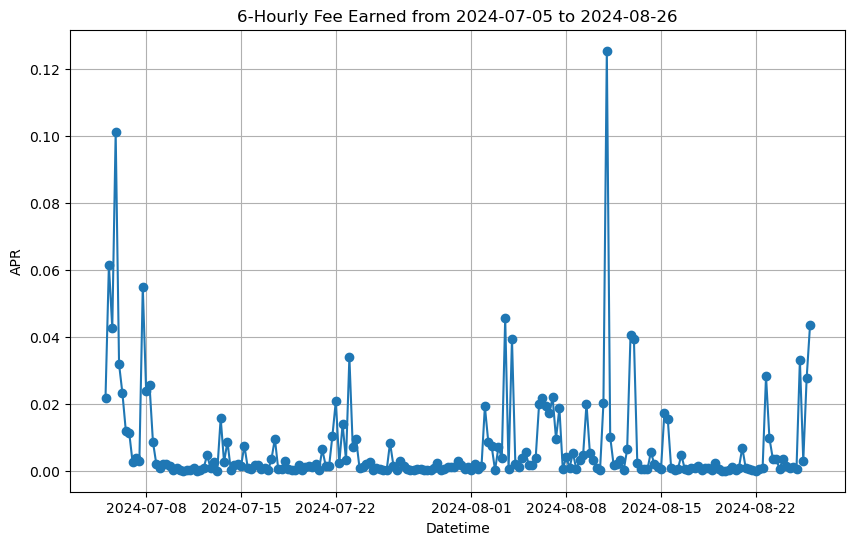

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(df_6hr_fee["Datetime"], df_6hr_fee["APR"], marker='o')
plt.title("6-Hourly Fee Earned from 2024-07-05 to 2024-08-26")
plt.xlabel("Datetime")
plt.ylabel("APR")
plt.grid(True)
plt.show()


In [37]:
# Define the ticker symbol and date range
ticker = 'ETH-USD'  # Ethereum to USD
start_date = '2024-07-05'
end_date = '2024-08-27'

# Download hourly data
data = yf.download(ticker, start=start_date, end=end_date, interval='1h')
data = data.reset_index()
# Ensure data is available
if not data.empty:
    # Calculate hourly returns
    data['Hourly_Returns'] = data['Close'].pct_change()

    # Calculate 6-hour rolling volatility (standard deviation of returns)
    data['6H_Rolling_Volatility'] = data['Hourly_Returns'].rolling(window=6).std()

    # Drop initial NaN values due to rolling calculation
    data = data.dropna(subset=['6H_Rolling_Volatility'])

    # Display the data
    print(data.head(10))
else:
    print("No data available for the specified date range.")


[*********************100%%**********************]  1 of 1 completed

                    Datetime         Open         High          Low  \
6  2024-07-05 06:00:00+00:00  2900.812744  2900.812744  2847.264404   
7  2024-07-05 07:00:00+00:00  2861.143555  2879.680664  2852.079102   
8  2024-07-05 08:00:00+00:00  2880.936768  2881.854492  2852.310303   
9  2024-07-05 09:00:00+00:00  2850.706055  2881.758057  2826.014404   
10 2024-07-05 10:00:00+00:00  2882.311035  2928.872070  2875.855225   
11 2024-07-05 11:00:00+00:00  2914.665527  2953.418457  2914.665527   
12 2024-07-05 12:00:00+00:00  2945.744385  2958.921875  2935.583496   
13 2024-07-05 13:00:00+00:00  2935.435059  2975.499023  2928.650879   
14 2024-07-05 14:00:00+00:00  2972.876709  2973.451904  2939.981445   
15 2024-07-05 15:00:00+00:00  2955.860840  3001.425537  2952.961914   

          Close    Adj Close     Volume  Hourly_Returns  6H_Rolling_Volatility  
6   2859.445801  2859.445801  622532608       -0.012471               0.016468  
7   2878.168213  2878.168213  376733696        0.006548 

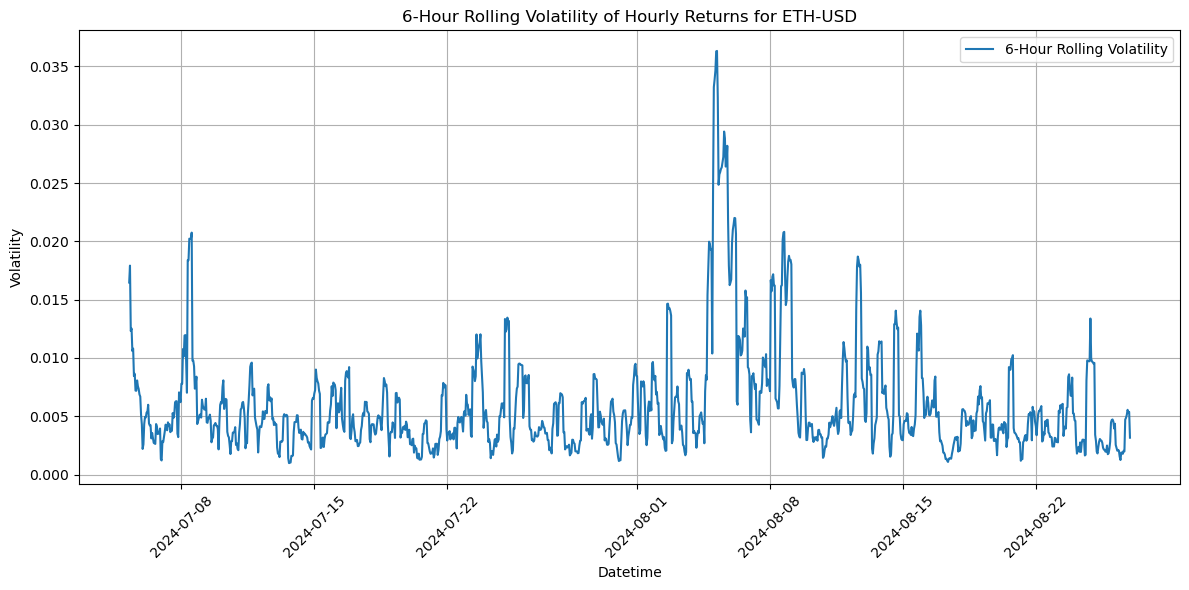

In [38]:
# Plot the 6-hour rolling volatility
plt.figure(figsize=(12, 6))
plt.plot(data["Datetime"], data['6H_Rolling_Volatility'], label='6-Hour Rolling Volatility')
plt.xlabel('Datetime')
plt.ylabel('Volatility')
plt.title('6-Hour Rolling Volatility of Hourly Returns for ETH-USD')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [39]:
volatality_6h = data[data['Datetime'].dt.hour%6 == 0].reset_index(drop = True)
print(volatality_6h[["Datetime","6H_Rolling_Volatility"]])

                     Datetime  6H_Rolling_Volatility
0   2024-07-05 06:00:00+00:00               0.016468
1   2024-07-05 12:00:00+00:00               0.008448
2   2024-07-05 18:00:00+00:00               0.007338
3   2024-07-06 00:00:00+00:00               0.002592
4   2024-07-06 06:00:00+00:00               0.005983
..                        ...                    ...
206 2024-08-25 18:00:00+00:00               0.002488
207 2024-08-26 00:00:00+00:00               0.004677
208 2024-08-26 06:00:00+00:00               0.002309
209 2024-08-26 12:00:00+00:00               0.001884
210 2024-08-26 18:00:00+00:00               0.004867

[211 rows x 2 columns]


In [40]:
# Ensure only 208 rows in volatality_6h
volatality_6h = volatality_6h.head(208)
print("df_6hr_fee columns:", df_6hr_fee.columns)
print("volatality_6h columns:", volatality_6h.columns)
df_6hr_fee['Datetime'] = pd.to_datetime(df_6hr_fee['Datetime']).dt.tz_localize(None)
volatality_6h['Datetime'] = pd.to_datetime(volatality_6h['Datetime']).dt.tz_localize(None)


# Adjust for correct capitalization in column names
correlation_columns = pd.merge(
    df_6hr_fee[['Datetime', 'APR']],       # Use 'Datetime' with uppercase 'D'
    volatality_6h[['Datetime', '6H_Rolling_Volatility']],  # Also with 'Datetime' column
    on='Datetime',                         # Merge on 'Datetime' with uppercase 'D'
    how='inner'                            # Use 'inner' join to keep only matching rows
)

# Display the result
print(correlation_columns)


df_6hr_fee columns: Index(['Datetime', 'total_fee_earned', '6_hour_yield', 'APR'], dtype='object')
volatality_6h columns: Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Hourly_Returns', '6H_Rolling_Volatility'],
      dtype='object')
               Datetime       APR  6H_Rolling_Volatility
0   2024-07-05 06:00:00  0.061454               0.016468
1   2024-07-05 12:00:00  0.042668               0.008448
2   2024-07-05 18:00:00  0.101113               0.007338
3   2024-07-06 00:00:00  0.031887               0.002592
4   2024-07-06 06:00:00  0.023138               0.005983
..                  ...       ...                    ...
203 2024-08-25 00:00:00  0.000618               0.009642
204 2024-08-25 06:00:00  0.033134               0.001808
205 2024-08-25 12:00:00  0.002978               0.002726
206 2024-08-25 18:00:00  0.027782               0.002488
207 2024-08-26 00:00:00  0.043592               0.004677

[208 rows x 3 columns]


In [41]:
correlation = correlation_columns['APR'].corr(correlation_columns['6H_Rolling_Volatility'])
print("Correlation between column1 and column2:", correlation)


# Shift the '6H_Rolling_Volatility' by 1 to align with the next row in 'APR'
correlation_columns['Lagged_Volatility'] = correlation_columns['6H_Rolling_Volatility'].shift(1)
print(correlation_columns)
# Calculate the correlation between 'APR' and the lagged '6H_Rolling_Volatility'
correlation = correlation_columns['APR'].corr(correlation_columns['Lagged_Volatility'])
print("Correlation between APR[1] and 6H_Rolling_Volatility[0]:", correlation)


Correlation between column1 and column2: 0.046735662406740264
               Datetime       APR  6H_Rolling_Volatility  Lagged_Volatility
0   2024-07-05 06:00:00  0.061454               0.016468                NaN
1   2024-07-05 12:00:00  0.042668               0.008448           0.016468
2   2024-07-05 18:00:00  0.101113               0.007338           0.008448
3   2024-07-06 00:00:00  0.031887               0.002592           0.007338
4   2024-07-06 06:00:00  0.023138               0.005983           0.002592
..                  ...       ...                    ...                ...
203 2024-08-25 00:00:00  0.000618               0.009642           0.009742
204 2024-08-25 06:00:00  0.033134               0.001808           0.009642
205 2024-08-25 12:00:00  0.002978               0.002726           0.001808
206 2024-08-25 18:00:00  0.027782               0.002488           0.002726
207 2024-08-26 00:00:00  0.043592               0.004677           0.002488

[208 rows x 4 columns]
Co

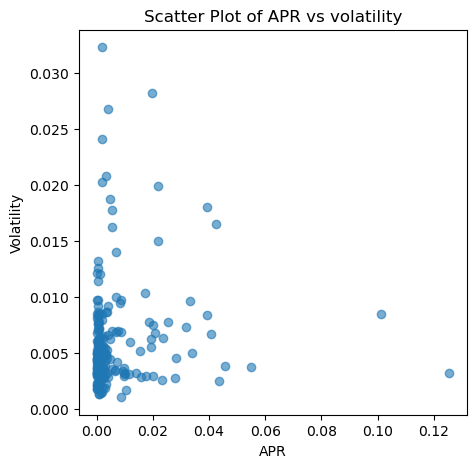

In [42]:

# Assuming df is your DataFrame
plt.figure(figsize=(5, 5))
plt.scatter(correlation_columns['APR'], correlation_columns['Lagged_Volatility'], alpha=0.6)
plt.title("Scatter Plot of APR vs volatility")
plt.xlabel("APR")
plt.ylabel("Volatility")
plt.show()


In [43]:
spearman_corr = correlation_columns['APR'].corr(correlation_columns['Lagged_Volatility'], method='spearman')
print("Spearman Correlation:", spearman_corr)


kendall_corr = correlation_columns['APR'].corr(correlation_columns['Lagged_Volatility'], method='kendall')
print("Kendall Tau Correlation:", kendall_corr)

distance_corr = dcor.distance_correlation(correlation_columns['APR'][1:], correlation_columns['Lagged_Volatility'][1:])
print("Distance Correlation:", distance_corr)

Spearman Correlation: 0.14167776082085914
Kendall Tau Correlation: 0.0899113550021106
Distance Correlation: 0.19558161668606808


In [56]:
# Define thresholds for APR based on quantiles
# low_apr = correlation_columns['APR'].quantile(0.33)
apr_threshold = correlation_columns['APR'].quantile(0.6)
print("APR threshold", apr_threshold)
# Create target labels based on APR
correlation_columns['APR_classification'] = correlation_columns['APR'].apply(
    lambda x: 'Low' if x <= apr_threshold else 'High'
)

# print(correlation_columns)
X = correlation_columns[['6H_Rolling_Volatility']]  # Feature
y = correlation_columns['APR_classification']       # Target labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree model
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train, y_train)

# Make predictions
y_pred = cart_model.predict(X_test)
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


APR threshold 0.002254979218198632
Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

        High       0.39      0.39      0.39        23
         Low       0.65      0.65      0.65        40

    accuracy                           0.56        63
   macro avg       0.52      0.52      0.52        63
weighted avg       0.56      0.56      0.56        63



In [63]:
#Example
volatility_val = np.array(0.001).reshape(-1, 1) 
y_pred2 = cart_model.predict(volatility_val)  # This will reshape it to a 2D column vector

print("x = ", volatility_val, "y = ", y_pred2)

x =  [[1.e-09]] y =  ['High']


C:\Users\molak\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [52]:
import joblib
joblib.dump(cart_model, 'decision_tree_model.pkl')


['decision_tree_model.pkl']